In [2]:
%load_ext sql

In [3]:
%env DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos

env: DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos


In [86]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

import spacy
import pickle

from unionfind import UnionFind

In [5]:
nlp = spacy.load("es_core_news_sm")

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 5]

In [92]:
import statistics

def summarize(l: list):
    print("Size:", len(l), sep="\t")
    print("Min:", min(l), sep="\t")
    print("Median:", statistics.median(l), sep="\t")
    print("Max:", max(l), sep="\t")
    print("Avg:", sum(l) / len(l), sep="\t")
    print("Mode:", statistics.mode(l), sep="\t")

# Exploración básica

In [7]:
%%sql

SELECT MEN_CONTENIDO
FROM MENSAJES_INGENIERIA
LIMIT 10

10 rows affected.


MEN_CONTENIDO
"Esta es una nueva herramienta que ha desarrollado la Escuela de Ingeniería y Ciencias cuyo propósito es facilitar la participación en temas de interés para nuestros alumnos, exalumnos, académicos y autoridades de nuestra Facultad."
"Felicitaciones por esta iniciativa , espero que todos sepamos darle un buen uso y sea un medio de apoyo a nuestras labores."
"Esta es una nueva herramienta que ha desarrollado la Escuela de Ingeniería y Ciencias cuyo propósito es facilitar la participación en temas de interés para nuestros alumnos, exalumnos, académicos y autoridades de nuestra Facultad."
vaya me puse click sin querer en el mensage anterior.. pero lo q queria decir es q me parece una gran idea. sigan adelante :)
"Felicitaciones por la iniciativa, espero que sepamos darle un buen uso a esto y que realmente la escuela sepa darle un buen uso tambián. Saludos"
"Me parece muy bien que hayan hecho un foro que imagino que es muy seguro, aunque es una pena que no todo el mundo se haya acostumbrado (o no les hayan enseñado) a usar las news, que deberian ser el canal de discusion por defecto. Para empezar, escribo esto desde mi casa porque como los computinomanos se habran dado cuenta, las salas de computadores están inhabilitadas hasta nuevo aviso. Con los pocos dias disponibles para el modifica, me parece bastante serio, porque no toda la gente tiene conexión en su casa, y los computadores del zócalo no dan abasto."
...na que decir..toda la razon...
"voy directo al grano... Considero que el tiempo que se nos da para almorzar en esta escuela es insuficiente. Considerando que este tiempo se comparte con: 1. profesores que no terminan sus clases a tiempo. 2. traslado al lugar donde se va a almorzar. 3. espera en el mismo restaurant. 4. buscar un baño para aseo bucal. 5. retorno a las salas de clases (a veces, el trayecto es largo). 6. un MÍNIMO DE TIEMPO PARA REPOSAR. Es hora que nos acerquemos a nuestro centro de estudiantes, para exigir cambios en los horarios de colación. Si nos unimos por esta causa, lograremos los cambios que necesitamos los alumnos. Acércate al CEI con tus quejas."
"Propongo desde ya que se cree otro foro con el tema ""Panoramas en la Escuela"" Cuyo unico fin sea publicar conciertos, exposiciones, actividades, presentaciones...etc. Espero les guste la idea!"
"mas que aumentar el tiempo para almorzar, creo que la crisis alimenticia de la escuela no pasa por eso. Creo que el problema radica en la POCA CALIDAD de alimentaciòn que los buchefianos estamos obteniendo. Quizás este año las cosas cambien, pero muy bien saben que la comida del casino es muy mala, que durante el año anterior la cafeta del CEI (mal ventilada y muy cochina) estuvo cerrada, que la muchos estudiantes derivaron a comer simples sandwich comprados en la calle o en algunos de los kioskos y locales dentro y en las cercanías de la facultad. Yo creo que el tema no solo pasa por el Centro de Estudiantes, si no también por las autoridades de la escuela, las cuales no solo deben velar por la formación academica de los Estudiantes, si no tambien por aquella cosa mas importante como es el bienestar de ellos."


In [8]:
%%sql

SELECT MEN_TITULO
FROM MENSAJES_INGENIERIA
LIMIT 10

 * mysql+mysqlconnector://root@localhost/ucursos
10 rows affected.


MEN_TITULO
Bienvenidos al Foro de Ingeniería
Felicitaciones
Re: Bienvenidos al Foro de Ingeniería
Re: Re: Bienvenidos al Foro de Ingeniería
Felicitaciones
buena idea Y para empezar
Re: buena idea Y para empezar
más tiempo para almorzar
propongo nuevo foro (tema aparte)
Re: más tiempo para almorzar


In [9]:
%%sql textos <<

SELECT MEN_ID, MEN_MEN_ID, MEN_TEM_ID, MEN_FECHA_CREACION, MEN_CONTENIDO
FROM MENSAJES_INGENIERIA

 * mysql+mysqlconnector://root@localhost/ucursos
1376786 rows affected.
Returning data to local variable textos


In [10]:
textos = textos.DataFrame()

## Largo de mensajes

In [112]:
largos = []
vocab = Counter()
for msg in tqdm(textos['MEN_CONTENIDO']):
    largos.append(len(msg))
    tokens = msg.lower().split()
    vocab.update(tokens)        

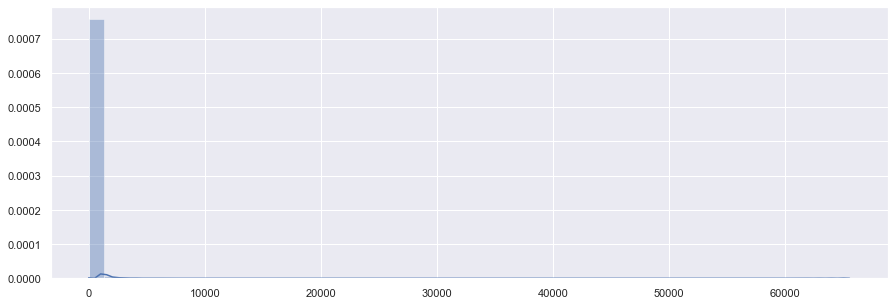

In [115]:
ax = sns.distplot(np.array(largos))

In [119]:
print("tamaño del vocabulario:", len(vocab))

tamaño del vocabulario: 1245261


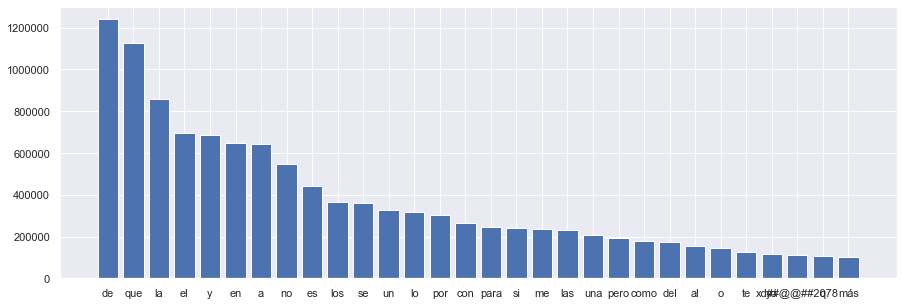

In [129]:
vocab_top20 = vocab.most_common(30)
tokens, freq = zip(*vocab_top20)

bar = plt.bar(x=tokens, height=freq)

# Usuarios y threads

In [138]:
%%sql df <<
SELECT MEN_RUT, MEN_MEN_ID, MEN_ID, MEN_FECHA_CREACION
FROM MENSAJES_INGENIERIA
WHERE MEN_CENSURADO = 0

 * mysql+mysqlconnector://root@localhost/ucursos
1376437 rows affected.
Returning data to local variable df


In [139]:
df = df.DataFrame()

In [140]:
df.head()

,MEN_RUT,MEN_MEN_ID,MEN_ID,MEN_FECHA_CREACION
0,9076922,0,11635,2002-03-11 12:16:44
1,11843791,0,11636,2002-03-11 14:29:30
2,15340775,11635,11637,2002-03-11 19:20:23
3,15340775,11637,11638,2002-03-11 19:21:33
4,13451009,0,11639,2002-03-11 20:20:12


In [180]:
len(df.index)

1376437

In [192]:
uf = UnionFind()
thread_ids = set()

for thread_id in df.loc[df.MEN_MEN_ID == 0]["MEN_ID"]:
    #uf.add(thread_id)
    thread_ids.add(thread_id)
    
#for msg_id in df.loc[df.MEN_MEN_ID != 0]["MEN_ID"]:
#    uf.add(msg_id)

In [193]:
for _, (men_id, parent_id) in tqdm(df.loc[df.MEN_MEN_ID != 0][["MEN_ID", "MEN_MEN_ID"]].iterrows(), 
                                   total=len(df.loc[df.MEN_MEN_ID != 0].index)):
    if parent_id not in thread_ids:
        continue
    uf.union(men_id, parent_id)

In [194]:
temas = list(uf.components())

In [187]:
with open('../data/foros/temas.list.pkl', 'wb') as f:
    pickle.dump(temas, f)

In [195]:
len(temas)

81015

In [147]:
msg_rut = dict()

for _, (rut, __, men_id, ___) in tqdm(df.iterrows(), total=len(df.index)):
    msg_rut[men_id] = rut

In [148]:
with open('../data/foros/msg_rut.dict.pkl', 'wb') as f:
    pickle.dump(msg_rut, f)

In [157]:
ruts_temas = list()

for tema in tqdm(temas):
    ruts = set()
    for msg_id in tema:
        #rut = df.loc[df.MEN_ID == msg_id].iloc[0]['MEN_RUT']
        rut = msg_rut[msg_id]
        ruts.add(rut)
    ruts_temas.append(ruts)

In [176]:
for tema in temas:
    if 11635 in tema:
        print(tema)

{11635, 11637}


## Cantidad de personas participando en un tema

In [196]:
uniq_personas_por_tema = [len(tema) for tema in ruts_temas]
mensajes_por_tema = [len(tema) for tema in temas]

[Text(0, 0.5, 'cantidad de temas'),
 Text(0.5, 0, 'usuarios distintos participando en el tema')]

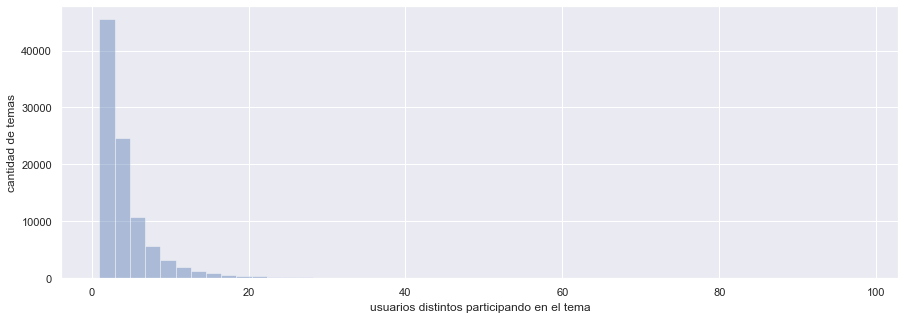

In [161]:
ax = sns.distplot(uniq_personas_por_tema, kde=False)
ax.set(xlabel="usuarios distintos participando en el tema", ylabel="cantidad de temas")

In [162]:
summarize(uniq_personas_por_tema)

Size:	96421
Min:	1
Median:	3
Max:	98
Avg:	4.090633783097044
Mode:	2


[Text(0, 0.5, 'cantidad de temas'), Text(0.5, 0, 'cantidad de mensajes')]

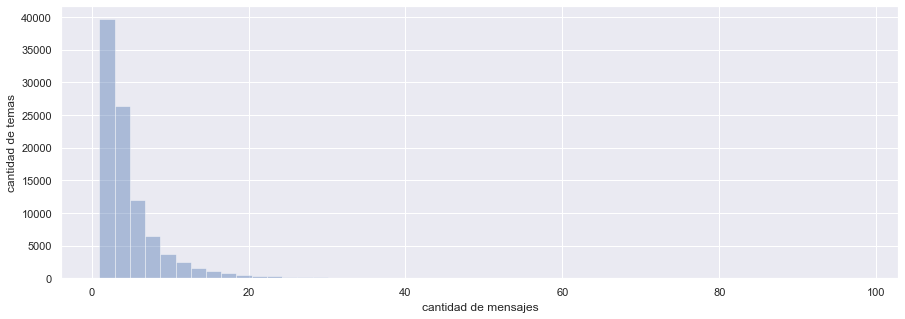

In [164]:
ax = sns.distplot(mensajes_por_tema, kde=False)
ax.set(xlabel="cantidad de mensajes", ylabel="cantidad de temas")

In [197]:
summarize(mensajes_por_tema)

Size:	81015
Min:	2
Median:	4
Max:	98
Avg:	5.315781028204653
Mode:	2


In [170]:
for tema in temas:
    if len(tema) == 98:
        print(tema)

{2152961, 2152963, 2152969, 2152971, 2152973, 2152977, 2152979, 2152981, 2152983, 2152993, 2153005, 2153007, 2153011, 2153013, 2153017, 2153019, 2153021, 2153023, 2153027, 2153029, 2153035, 2153037, 2153043, 2153049, 2153051, 2153053, 2153055, 2153057, 2153067, 2153069, 2153073, 2153075, 2153079, 2153081, 2153083, 2153085, 2153087, 2153093, 2153097, 2153099, 2153101, 2153103, 2153105, 2153107, 2153125, 2153145, 2153163, 2153165, 2153169, 2153173, 2153193, 2153197, 2153201, 2153205, 2153207, 2153229, 2153231, 2152815, 2152823, 2152837, 2152839, 2152841, 2152843, 2152847, 2152853, 2152857, 2152859, 2152861, 2152863, 2152867, 2152869, 2152873, 2152883, 2152885, 2152889, 2152893, 2152897, 2152901, 2152903, 2152909, 2152911, 2152913, 2152915, 2152919, 2152921, 2152923, 2152925, 2152927, 2152929, 2152933, 2152935, 2152937, 2152941, 2152947, 2152949, 2152951, 2152955, 2152957}
{2187779, 2187783, 2187791, 2187795, 2187447, 2187455, 2187461, 2187463, 2187465, 2187467, 2187469, 2187471, 2187477,